In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Image Classification with PyTorch (fully connected network)

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from IPython.display import display

## Declaring Dataloader [load data in NN a/c to batch size (if given)]

In [4]:
ris = resize_image_size = 64
train_data_path="/home/garvit/work_area/zone/Anaconda_WorkSpace/jupyter/PyTorch practice/PyTorch Book/chapter2/dataset/training_set/"
test_data_path="/home/garvit/work_area/zone/Anaconda_WorkSpace/jupyter/PyTorch practice/PyTorch Book/chapter2/dataset/test_set/"

# declaring some trasformations on images for NN feed i.e Scaling images, converting into tensors e.t.c
transformations = transforms.Compose([transforms.Resize((ris,ris)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                                      std = [0.229, 0.224, 0.225])])

# applying above transformations
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transformations)
# val_data   = torchvision.datasets.ImageFolder(root = val_data_path, transform=transforms) 
test_data  = torchvision.datasets.ImageFolder(root = test_data_path, transform=transformations)


# declaring DataLoader (load data in NN a/c to batch size if given)
BatchSize = 48
train_data_loader = DataLoader(dataset=train_data, batch_size = BatchSize, shuffle=True )
# val_data_loader = DataLoader(dataset=val_data, batch_size = BatchSize)
test_data_loader = DataLoader(dataset=test_data, batch_size = BatchSize, shuffle=True)


## Creating a FC Network

In [5]:
class ImageNetFC(nn.Module):
    def __init__(self):
#         nn.Module.__init__(self)
        super().__init__()
        self.fc1 = nn.Linear(3*ris*ris, 84) #3*64*64
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def forward(self,x):
        x = x.view(-1, 3*ris*ris) # convert the image to 3D vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)     # removing Softmax activation fn coz we are using "CrossEntropyLoss" as 
                            # a loss function which also have default Softmax function so no need to
                            # apply it on o/p layer
        return x
        
imagenet = ImageNetFC()


## Create an optimizer

In [7]:
from torch.optim import Adam, SGD
optimizer = SGD(params=imagenet.parameters(), lr=0.01)

## Checking for GPU

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

imagenet.to(device)

ImageNetFC(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

## Defining Training Function 

In [10]:
def train(model, optimiser, loss_fn, train_loader, val_loader, epochs=1, device='cpu'):
    for epoch in range(epochs):
            training_loss = 0
            valid_loss = 0
            model.train()
            for batch in train_loader:
#                 print(f"training batch: {batch}")
                optimizer.zero_grad()
                inputs, target = batch
#                 print(inputs)
                inputs = inputs.to(device)
                target = target.to(device)
                output = model(inputs)
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()
                training_loss += loss.data.item()
            training_loss /= len(train_loader.dataset)
            
            model.eval()
            num_correct = 0
            num_examples = 0
            for batch in val_loader:
                inputs, target = batch
                inputs = inputs.to(device)
                output = model(inputs)
                loss = loss_fn(output, target)
                valid_loss += loss.data.item()
                correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
            valid_loss /= len(val_loader.dataset)

            print(f'Epoch: {epoch+1},  Training Loss: {round(training_loss,3)}, \
            Validation Loss: {round(valid_loss,3)}, \
            accuracy = {round(num_correct / num_examples,2)}')            
            
    

## Enabling Training

In [11]:
train(imagenet, optimizer,nn.CrossEntropyLoss(), train_data_loader,test_data_loader, epochs=5, device=device)

/home/garvit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1,  Training Loss: 0.014,             Validation Loss: 0.014,             accuracy = 0.62
Epoch: 2,  Training Loss: 0.013,             Validation Loss: 0.014,             accuracy = 0.62
Epoch: 3,  Training Loss: 0.013,             Validation Loss: 0.013,             accuracy = 0.64
Epoch: 4,  Training Loss: 0.012,             Validation Loss: 0.013,             accuracy = 0.65
Epoch: 5,  Training Loss: 0.012,             Validation Loss: 0.013,             accuracy = 0.65


## Making predictions

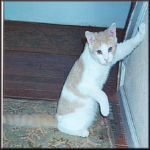

tensor([[0.7130, 0.2870]])
It's a Cat


/home/garvit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/home/garvit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


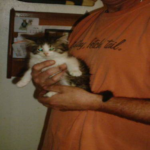

tensor([[0.5100, 0.4900]])
It's a Cat


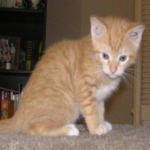

tensor([[0.7993, 0.2007]])
It's a Cat


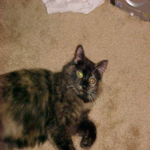

tensor([[0.7034, 0.2966]])
It's a Cat


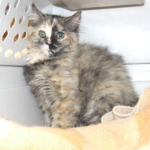

tensor([[0.1915, 0.8085]])
It's a Dog


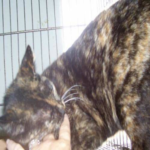

tensor([[0.5039, 0.4961]])
It's a Cat


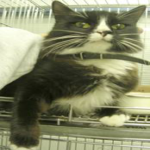

tensor([[0.5967, 0.4033]])
It's a Cat


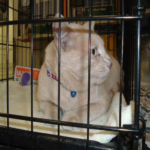

tensor([[0.8088, 0.1912]])
It's a Cat


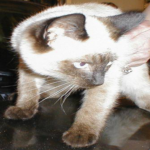

tensor([[0.5569, 0.4431]])
It's a Cat

predicted 8 cats out of 9 cats
accuracy on actual weights: 88.89%


In [13]:
model1 = imagenet
P = transforms.Resize((150,150))
labels = ['Cat','Dog']
cat_count = 0
dog_count = 0

for i in range(4001, 4010):
    img = Image.open(f"{test_data_path}cats/cat.{i}.jpg")
    display(P(img))
    img = transformations(img).to(device)
    prediction = F.softmax(model1(img))
    prediction = prediction.argmax()
    print(F.softmax(model1(img)).data)
    print(f"It's a {labels[prediction]}")
    cat_count+=1
    if labels[prediction] == 'Dog':
        dog_count+=1

print()    
print(f"predicted {cat_count-dog_count} cats out of {cat_count} cats")
print(f"accuracy on actual weights: {round(((cat_count-dog_count)/cat_count)*100,2)}%")


## Saving model

In [10]:
torch.save(imagenet, './simplenet')

## Loading the model

In [11]:
imagenet = torch.load('simplenet')

## Saving model state dict (it saves each layers parameter)

In [14]:
torch.save(imagenet.state_dict(), 'simplenet')
simplenet = SimpleNet()
simplenet_state_dict = torch.load('simplenet')
simplenet.load_state_dict(simplenet_state_dict)

<All keys matched successfully>